# Modelling poisson using PINN

Solving the poisson equation $-\Delta u = f$ using a physics informed neural network 

## 2D problem

### Manufactured solution


We use $u = sin(x+y)$ for $x\in [0,1]^2$ to manufacture the right hand side to be $f=-2sin(x+y)$ which is same as $f=-\Delta u$.

### Importing packages

In [264]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Manufacturing data for trainig

In [265]:
np.random.seed(123)
pde_data_size = 10000
dim_d = 2
X_tr_pde = np.random.uniform(-1,1,pde_data_size*dim_d).reshape(pde_data_size,dim_d)


### Looking at the scatter plot of genrated 2d points

Text(0.5, 1.0, 'Randomly generated collocation points')

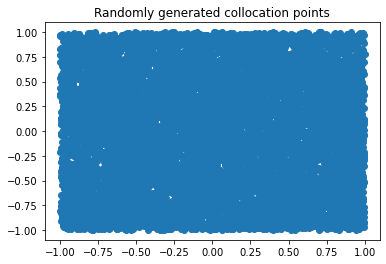

In [266]:
plt.scatter(X_tr_pde[:,0],X_tr_pde[:,1])
plt.title("Randomly generated collocation points")

### Defining RHS of pde

In [267]:
Y_tr_pde = -4*np.ones((X_tr_pde.shape[0],1))
# Y_tr_pde = X_tr_pde[:,0:1]


In [268]:
Y_tr_pde = np.concatenate([Y_tr_pde,np.zeros((Y_tr_pde.shape[0],1))],axis=1)
Y_tr_pde.shape

(10000, 2)

### Experiment with surface plotting( might help later while plotting the computed solution)

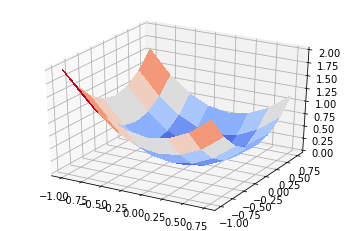

In [269]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = np.arange(-1, 1, 0.25)
Y = np.arange(-1, 1, 0.25)
X, Y = np.meshgrid(X, Y)
R = X**2 + Y**2
# Z = np.sin(R)

# Plot the surface.
surf = ax.plot_surface(X, Y, R, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)


## BC data 

In [270]:
bc_data_size = 500

X_bc_left = np.random.uniform(-1.,1.,bc_data_size).reshape(bc_data_size,1)
X_bc_left = np.concatenate([-1*np.ones((bc_data_size,1)), X_bc_left], axis=1)

X_bc_bottom = np.random.uniform(-1.,1.,bc_data_size).reshape(bc_data_size,1)
X_bc_bottom = np.concatenate([X_bc_bottom, -1*np.ones((bc_data_size,1))], axis=1)

X_bc_right = np.random.uniform(-1.,1.,bc_data_size).reshape(bc_data_size,1)
X_bc_right = np.concatenate([1*np.ones((bc_data_size,1)), X_bc_right], axis=1)

X_bc_top = np.random.uniform(-1.,1.,bc_data_size).reshape(bc_data_size,1)
X_bc_top = np.concatenate([X_bc_top, 1*np.ones((bc_data_size,1))], axis=1)

X_bc = np.concatenate([X_bc_left, X_bc_right, X_bc_bottom, X_bc_top],axis=0)

In [271]:
Y_bc = X_bc[:,0:1]**2 + X_bc[:,1:]**2 
Y_bc = np.concatenate([Y_bc, np.ones((Y_bc.shape[0],1))], axis=1 )

In [272]:
dom_data_size = 1000
X_domain  = np.random.uniform(-1,1,dom_data_size*dim_d).reshape(dom_data_size,dim_d)

Y_domain = X_domain[:,0:1]**2 + X_domain[:,1:]**2 
Y_domain = np.concatenate([Y_domain, np.ones((Y_domain.shape[0],1))], axis=1)

In [273]:
X_tr = np.concatenate((X_tr_pde, X_bc, X_domain), axis=0)
Y_tr = np.concatenate((Y_tr_pde, Y_bc, Y_domain), axis=0)

## Training the model

In [274]:
from tensorflow.keras import backend as K
class CustomModel(tf.keras.Model):

    def __init__(self):
        super(CustomModel, self).__init__()
        self.dense_1 = keras.layers.Dense(20, activation="elu",
                                          name="dense_1")
        self.dense_2 = keras.layers.Dense(20, activation="elu",
                                         name="dense_2")
        self.dense_3 = keras.layers.Dense(20, activation="elu",
                                         name="dense_3")
        self.dense_4 = keras.layers.Dense(1,
                                         name="dense_4")

    def findGrad(self,func,argm):
        try:
            return keras.layers.Lambda(lambda z: [tf.gradients(z[0],x_i,
                                                               unconnected_gradients='zero')
                                                  for x_i in z[1] ]) ([func,argm])
        except Exception as e:
            print("error occured in find gradient lambda layer of type {} as follows: ".format(type(e)),e)
            
            
    def findSecGrad(self,func,argm):
        try:
            # list containng diagonal entries of hessian matrix. Note that  tf.gradients 
            #returns a list of tensors and hence thats why we have  a [0] at the end of  
            #the tf.gradients fucntion as tf.gradients(func,argm) [0]
            del_sq_layer = keras.layers.Lambda( lambda z: [ tf.gradients(z[0][i], z[1][i],
                                                              unconnected_gradients='zero') [0]
                                                  for i in range(len(z[1])) ] ) ([func,argm])
            return sum(del_sq_layer)
                
        except Exception as e:
            print("Error occured in find laplacian lambda layer of type {} as follows: ".format(type(e)),e)
        
    def call(self, inputs):
        inputs_conc = keras.layers.concatenate(inputs) 
        layer_1 = self.dense_1(inputs_conc)
        layer_2 = self.dense_2(layer_1)
        layer_3 = self.dense_3(layer_2)
        layer_4 = self.dense_4(layer_3)
        grad_layer = self.findGrad(layer_4, inputs)
        laplace_layer = self.findSecGrad(grad_layer, inputs)
        
        
        return layer_4, laplace_layer




In [275]:
custom_model = CustomModel()

In [276]:
#Loss coming from the boundary terms
def u_loss(y_true, y_pred):
#     print("\n\nreached here 1 \n\n\n")
    y_true_act = y_true[:,:-1]
    at_boundary = tf.cast(y_true[:,-1:,],bool)
    u_sq_error = (1/2)*tf.square(y_true_act-y_pred)
#     print("\n\nreached here 2 \n\n\n")
#     print("\nu_loss: ",tf.where(at_boundary, u_sq_error, 0.))
    return tf.where(at_boundary, u_sq_error, 0.)

#Loss coming from the PDE constrain
def pde_loss(y_true, y_pred):
    y_true_act = y_true[:,:-1]
    at_boundary = tf.cast(y_true[:,-1:,],bool)
    #need to change this to just tf.square(y_pred) after pde constrain is added to grad_layer
    pde_sq_error = (1/2)*tf.square(y_true_act-y_pred)
#     print("\npde_loss: ",tf.where(at_boundary,0.,pde_sq_error))
    return tf.where(at_boundary,0.,pde_sq_error)

In [277]:
custom_model.compile(loss=[u_loss,pde_loss], optimizer="nadam", loss_weights=[0.5,0.5])
# custom_model.compile(loss=u_loss, optimizer=keras.optimizers.SGD(lr=1e-3))

In [280]:
custom_model.fit(x=[X_tr[:,0:1], X_tr[:,1:2]], y=[Y_tr, Y_tr], epochs=10)

Epoch 1/10
407/407 [==============================] - 4s 9ms/step - loss: 0.1055 - output_1_loss: 0.1042 - output_2_loss: 0.1068
Epoch 2/10
407/407 [==============================] - 3s 8ms/step - loss: 0.1002 - output_1_loss: 0.1024 - output_2_loss: 0.0979
Epoch 3/10
407/407 [==============================] - 4s 9ms/step - loss: 0.1004 - output_1_loss: 0.1004 - output_2_loss: 0.1003
Epoch 4/10
407/407 [==============================] - 4s 9ms/step - loss: 0.0991 - output_1_loss: 0.0990 - output_2_loss: 0.0993
Epoch 5/10
407/407 [==============================] - 3s 7ms/step - loss: 0.1008 - output_1_loss: 0.0992 - output_2_loss: 0.1024
Epoch 6/10
407/407 [==============================] - 4s 9ms/step - loss: 0.0938 - output_1_loss: 0.0995 - output_2_loss: 0.0880
Epoch 7/10
407/407 [==============================] - 3s 9ms/step - loss: 0.0913 - output_1_loss: 0.0984 - output_2_loss: 0.0842
Epoch 8/10
407/407 [==============================] - 4s 11ms/step - loss: 0.0929 - output_1_loss

In [284]:
custom_model.compile(loss=[u_loss,pde_loss], optimizer=keras.optimizers.SGD(lr=1e-4))
custom_model.fit(x=[X_tr[:,0:1], X_tr[:,1:2]], y=[Y_tr, Y_tr], epochs=10)

Epoch 1/10
407/407 [==============================] - 3s 7ms/step - loss: 0.1370 - output_1_loss: 0.0992 - output_2_loss: 0.0378
Epoch 2/10
407/407 [==============================] - 2s 5ms/step - loss: 0.1369 - output_1_loss: 0.0994 - output_2_loss: 0.0376
Epoch 3/10
407/407 [==============================] - 3s 7ms/step - loss: 0.1365 - output_1_loss: 0.0994 - output_2_loss: 0.0371
Epoch 4/10
407/407 [==============================] - 3s 8ms/step - loss: 0.1362 - output_1_loss: 0.0994 - output_2_loss: 0.0368
Epoch 5/10
407/407 [==============================] - 3s 7ms/step - loss: 0.1370 - output_1_loss: 0.0995 - output_2_loss: 0.0374
Epoch 6/10
407/407 [==============================] - 4s 9ms/step - loss: 0.1364 - output_1_loss: 0.0995 - output_2_loss: 0.0369
Epoch 7/10
407/407 [==============================] - 3s 8ms/step - loss: 0.1367 - output_1_loss: 0.0995 - output_2_loss: 0.0372
Epoch 8/10
407/407 [==============================] - 3s 8ms/step - loss: 0.1364 - output_1_loss:

### Testing the model

In [285]:
X_test_st = np.random.uniform(-0.5,0.5,20*dim_d).reshape(20,dim_d)

In [286]:
# X_test_st = X_tr[-100:,:]

In [287]:

#custom_model.evaluate(x=[X_test_st[:,0:1], X_test_st[:,1:2]], y=[Y_tr[-100:,:], Y_tr[-100:,:]])

In [288]:
Y_test = custom_model.predict([X_test_st[:,0:1], X_test_st[:,1:2]])[0]
Y_test

array([[2.1361628],
       [1.8713897],
       [2.1380248],
       [2.1043553],
       [1.8242548],
       [1.7547916],
       [2.0145545],
       [2.0617893],
       [2.1295898],
       [1.9941039],
       [1.9281291],
       [2.1344275],
       [2.1465013],
       [1.8944652],
       [1.8785386],
       [1.9547235],
       [2.0806828],
       [1.9869438],
       [1.8393492],
       [2.0847867]], dtype=float32)

In [289]:
# np.concatenate((Y_tr[-100:,:],Y_test), axis=1)

In [290]:
X_test_st[:,0:1]**2 + X_test_st[:,1:2]**2

array([[0.0257765 ],
       [0.28397049],
       [0.02148018],
       [0.09418306],
       [0.38412633],
       [0.43417973],
       [0.15638981],
       [0.12702477],
       [0.03559214],
       [0.14010602],
       [0.2460426 ],
       [0.02548305],
       [0.01684438],
       [0.2205609 ],
       [0.30172153],
       [0.19740249],
       [0.12028279],
       [0.22939151],
       [0.29178075],
       [0.06884406]])

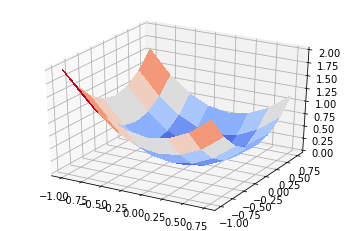

In [57]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = np.arange(-1, 1, 0.25)
Y = np.arange(-1, 1, 0.25)
X, Y = np.meshgrid(X, Y)
R = X**2 + Y**2
# Z = np.sin(R)

# Plot the surface.
surf = ax.plot_surface(X, Y, R, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
